In [327]:
%matplotlib inline
import MySQLdb as mdb
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set()

from datetime import datetime
import re

matplotlib.style.use('ggplot')
#pd.set_option('display.notebook_repr_html', True)

# Helper Functions 

### Fetch Data From MySQL

In [6]:
def fetch(cols,table,where=None,group_by=None,order_by=None,Desc=False,limit=None):
    """
    Purpose: Makes the MySQL quesries more efficitent and faster.
    
    Note: All inputs have to be in STRING format except the 'limit' which is an int
    """
    
    # Opening a Connection to donorsChoose Database
    con = mdb.connect('localhost', 'idx', 'donorsChoose', 'donors');
    cur = con.cursor()
    
    # Creating a query
    query = 'SELECT ' + cols + ' FROM ' + table + ' '
    if where: query += ' WHERE ' + where + ' '
    if group_by: query += 'GROUP BY ' + group_by + ' '
    if order_by: query += 'ORDER BY ' + order_by + ' '
    if Desc: query += 'DESC '
    if limit: query += 'LIMIT ' + str(limit)
    
    # fetching the data and turn it into a pandas dataframe
    cur.execute(query)
    output = np.array(cur.fetchall())
    colm = [f[0] for f in cur.description]
    output = pd.DataFrame(output)
    output.columns = colm

    # Closing the connection to the database
    con.close()
    
    return output

### Statistical Analysis Functions 

In [189]:
def chi2_test(colName):
    '''
    Purpose: Performs Chi2 independet test on a categorical variable column
    and return the associated p-value.
    
    Note: This function is specifically designed for LA projects and the 
    independent test perfomed based on the funding status (funded or not)
    '''
    
    # Create a multiIndex_table table based on the variable and funding status
    multiIndex_table = projects_la.groupby([colName,'funding_status'])['funding_status'].count()
               
    # Turning funding status into two columns (completed/expired)
    unstacked = multiIndex_table.unstack('funding_status')

    # Making sure that there are at least 10 observation per case
    unstacked = unstacked[unstacked.completed >= 10]
    unstacked = unstacked[unstacked.expired >= 10]
    
    Chi2, p_value, dof, expected = scipy.stats.chi2_contingency(unstacked)
    
    return p_value

In [400]:
def bootstrap_median(colName,nofSimulation=1000,nofSample=1000,plot_hist=False):
    """
    Purpose: Performs two groups independent tests and compares their median
    
    Note: This function is specifically designed for LA projects and the 
    independent test perfomed based on the funding status (funded or not)
    """
    
    median_diff = []
    
    Funded    = projects_la[projects_la.funding_status=='completed']
    notFunded = projects_la[projects_la.funding_status=='expired']

    # Bootstraping: finding the median differences and severl (nofSimulation) resample of
    # funded and not funded projects. 
    for i in xrange(nofSimulation):
        median1 = Funded[colName].iloc[np.random.randint(0, len(Funded[colName]), size=nofSample)].median()
        median2 = notFunded[colName].iloc[np.random.randint(0, len(notFunded[colName]), size=nofSample)].median()
        median_diff.append(median1 - median2)

    # The number of simulations and resample size will be more than
    # couple of thousands --> use normal z test (CLT)
    mean = np.mean(median_diff)
    SD = np.std(median_diff)
    z = mean/SD
    z = min(-z,z)  # Two sided test --> use the lower quantile
    pValue = 2*stats.norm.cdf(z)
    percLow, percHigh = np.percentile(median_diff,[2.5,97.5])


    print 'The mean of median difference of {0} is {1}, the confidence interval=({2},{3}), and  p-value={4}.'.\
            format(colName,round(mean,2),round(percLow,2),round(percHigh,2),round(pValue,2))
    print
    
    if plot_hist:
        plt.hist(median_diff)   # Optional 

In [141]:
def sampleProportions_chanceOF_success(colName):
    """
    Purpose: Determine wether or not a binary variable contributes to the success probability
    
    Example: Is being a charter school on not correlated to the chance of getting funded.
    
    Note: This function is specifically designed for LA projects and the 
    independent test perfomed based on the funding status (funded or not)
    """
    
    # prevalence of the binary varible: what is the prevalence of the charter school?
    prevalence = float(sum(projects_la[colName] == '1'))

    # Conditional Probability: If it's a charter school, what is the chance of getting funded?
    success = sum(projects_la[projects_la[colName] == '1']['funding_status'] == 'completed')
    
    # Overal success rate: independent of wether or not it's a charter school
    overal_success = sum(projects_la.funding_status == 'completed')/float(projects_la.shape[0])
    
    # funded given it's a charter school
    p = success/prevalence
    sigma = np.sqrt(p*(1-p)/prevalence)
    percLow = p - 1.96*sigma
    percHigh = p + 1.96*sigma
    
    # Confident interval of success rate compare to the overal success
    return (percLow - overal_success, percHigh - overal_success)

### Plotting 

In [195]:
def plot_proportions(colName,figSize = (14,19)):
    """
    Purpose: Plots stacked barplots for categorical variable
    
    Note: This function is specifically designed for LA projects and the 
    independent test perfomed based on the funding status (funded or not)
    """
    
    # Create a multiIndex_table table based on the variable and funding status
    multiIndex_table = projects_la.groupby([colName,'funding_status'])['funding_status'].count()
    
    # Turning one of the indices into a column
    multiIndex_table = multiIndex_table.unstack('funding_status')
    
    # Normalizing each row
    multiIndex_table = multiIndex_table.div(multiIndex_table.sum(axis=1), axis=0)
    
    # Making it more readable
    font = {'weight' : 'bold', 'size': 13}
    matplotlib.rc('font', **font)

    ax = multiIndex_table.sort('completed').plot(kind='barh',stacked=True,figsize=figSize)
    ax.set_title('Percentage Funded vs. ' + colName)

# Fetching LA Projects

DonorsChoose data is already parsed and stored on the local machine and can be access via a MySQL connection. For now, I am going to work on projects data only. I will look at the donations and essays separately.

Let's retrieve all the projects that are done in LA county.

In [412]:
projects_la = fetch('*','projects',where="school_county='Los Angeles'")

In [413]:
print '(numofRows, numofColms) =' , projects_la.shape

(numofRows, numofColms) = (54067, 44)


In [414]:
projects_la.head()

,_projectid,_teacher_acctid,_schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration
0,"""""""2d5b520776306c5045773b5967b2489b""""""","""""""e4c4e0f20f829889bf5dea5b86a53167""""""","""""""5eb8abe6cd0a27efa1287f147dc40569""""""",060962000970,33.884496,-118.261193,Carson,CA,90746,urban,...,80,1346.48,8,0,0,completed,2005-08-26,2005-12-05,2006-04-19,2006-04-26
1,"""""""0034afc6a1b71df3cc9927b353b21677""""""","""""""80e001267354e9e6b61eb08a37d5e7a7""""""","""""""5eb8abe6cd0a27efa1287f147dc40569""""""",060962000970,33.884496,-118.261193,Carson,CA,90746,urban,...,90,1057.34,1,0,0,completed,2005-08-22,2005-08-25,2005-11-08,2006-04-22
2,"""""""d418d916e635e3bce6f8b3a4958f0fda""""""","""""""60e8acc2d87acea355900bd27fb0602f""""""","""""""bee98bc28f4e5877c3a0dcfb1afe2203""""""",062271003017,34.019176,-118.306340,Los Angeles,CA,90018,urban,...,90,613.75,3,0,0,completed,2005-08-26,2005-12-21,2006-03-03,2006-04-26
3,"""""""1fa48a4ff77363363c5c32ab6d9ef89b""""""","""""""80e001267354e9e6b61eb08a37d5e7a7""""""","""""""5eb8abe6cd0a27efa1287f147dc40569""""""",060962000970,33.884496,-118.261193,Carson,CA,90746,urban,...,90,3224.58,4,0,0,completed,2005-08-22,2006-10-19,2007-05-10,2006-04-22
4,"""""""3c6448cd34bb451adf5ced0e56da4cc9""""""","""""""1dae23a46c9880f565278725ce8064a0""""""","""""""439e18432181f6357930db095bf938a4""""""",060962000991,33.900922,-118.261918,Compton,CA,90220,urban,...,20,482.11,1,0,0,completed,2005-08-24,2005-08-24,None,2006-05-15


To make our life easier, let's create a numerical binary column for funding status

In [415]:
# Have a column of success and failures as 1 & 0 for the ease of calculation
projects_la['funding_status_binary'] = projects_la.funding_status.map( {'completed': 1, 'expired': 0}).astype(int)

### Dropping Unrelevant Columns

Information about the state/county and 'teacher_ny_teaching_fellow' are clearly redundant; these are projecy LA county. Also, it turned out there is no New Leaders New Schools (nlns) in LA. 

In [416]:
projects_la.drop(['school_state','school_county','teacher_ny_teaching_fellow','school_nlns'], axis=1, inplace=True)
print '(numofRows, numofColms) =' , projects_la.shape

(numofRows, numofColms) = (54067, 41)


# Correcting for MySQL dtype Assignments

The fetched data through MySQL are all labeled as object (categorical) data type. Need to correct that for numerical and timestamp data.

### Correting Numerical Columns dtype

In [417]:
numerical_columns = ['vendor_shipping_charges', 'sales_tax', 'payment_processing_charges', \
                     'fulfillment_labor_materials','total_price_excluding_optional_support',\
                     'total_price_including_optional_support', 'students_reached','total_donations','num_donors']

projects_la[numerical_columns] = projects_la[numerical_columns].astype(float)

### Correting Timestamp Columns dtype

In [418]:
timestamp_columns = ['date_posted', 'date_completed','date_thank_you_packet_mailed','date_expiration']

for column in timestamp_columns:
    projects_la[column] = pd.to_datetime(projects_la[column])

In [419]:
projects_la.dtypes.value_counts()

object            27
float64            9
datetime64[ns]     4
int64              1
dtype: int64

Okay, everything looks good. Let's see how LA is doing.

# LA in the Last 10 Years

What fraction of the projects are funded? How much money is raised? What about not funded projects?

In [420]:
projects_la.groupby('funding_status').total_price_including_optional_support.sum()

funding_status
completed    24640797.09
expired      12833492.76
Name: total_price_including_optional_support, dtype: float64

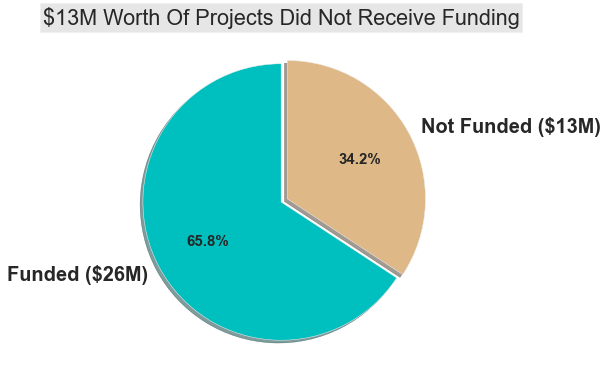

In [421]:
# make a square figure and axes
plt.rcParams['font.size'] = 15.0
plt.figure(1, figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

# The slices will be ordered and plotted counter-clockwise.
labels = ['Funded ($26M)', 'Not Funded ($13M)']
fracs = [24640797.09, 12833492.76]
explode=(0, 0.05)
colors=( 'c', 'burlywood')

patches, texts, autotext = plt.pie(fracs, explode=explode, labels=labels ,colors=colors,
                autopct='%1.1f%%', shadow=True, startangle=90)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

# Changing the labels font size
texts[0].set_fontsize(20)
texts[1].set_fontsize(20)

plt.title('$13M Worth Of Projects Did Not Receive Funding', bbox={'facecolor':'0.9', 'pad':7})

plt.show()

In [422]:
projects_la.groupby('funding_status').students_reached.sum()

funding_status
completed    2895658
expired      2202529
Name: students_reached, dtype: float64

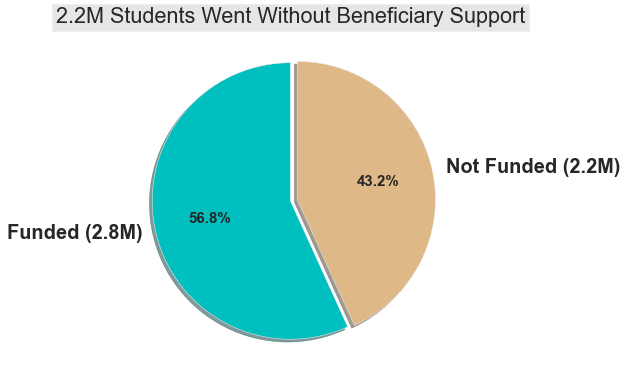

In [423]:
# make a square figure and axes
plt.rcParams['font.size'] = 15.0
plt.figure(1, figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

# The slices will be ordered and plotted counter-clockwise.
labels = 'Funded (2.8M)', 'Not Funded (2.2M)'
fracs = [2895658 , 2202529 ]
explode=(0, 0.05)
colors=( 'c', 'burlywood')

patches, texts, autotext = plt.pie(fracs, explode=explode, labels=labels ,colors=colors,
                autopct='%1.1f%%', shadow=True, startangle=90)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

# Changing the labels font size
texts[0].set_fontsize(20)
texts[1].set_fontsize(20)

plt.title('2.2M Students Went Without Beneficiary Support', bbox={'facecolor':'0.9', 'pad':7})

plt.show()

# Analyzing Categorical Variables with Two Levels

They are several binary variables but only two classes: type of school, type of teacher, and different types of promotions. Let's see what's the enhanced chance of success for each of these variables.

In [424]:
binary_variables = projects_la[['school_charter','school_magnet','school_year_round',\
                            'school_kipp','school_charter_ready_promise','teacher_teach_for_america',\
                            'eligible_double_your_impact_match','eligible_almost_home_match']]

In [425]:
enhanced_chance = pd.DataFrame([sampleProportions_chanceOF_success(x) for x in binary_variables]).T
enhanced_chance.columns = binary_variables.columns
enhanced_chance.index = [['2.5%_percentile_Increased_Chance_of_Success',\
                          '97.5%_percentile_Increased_Chance_of_Success']]
enhanced_chance.T.sort(['2.5%_percentile_Increased_Chance_of_Success',\
                          '97.5%_percentile_Increased_Chance_of_Success'],ascending=False).T

,eligible_double_your_impact_match,teacher_teach_for_america,eligible_almost_home_match,school_charter_ready_promise,school_charter,school_kipp,school_magnet,school_year_round
2.5%_percentile_Increased_Chance_of_Success,0.06964,0.064965,0.060146,0.048277,0.026760,0.002358,-0.006007,-0.049089
97.5%_percentile_Increased_Chance_of_Success,0.07981,0.094497,0.083997,0.081138,0.043568,0.087497,0.011666,-0.026026


Here is the apparent order of predictive values of the binary variables:

1. eligible_double_your_impact_match (half of the projects is covered by a sponsor)
2. teacher_teach_for_america
3. eligible_almost_home_match (the last $100 of the price is covered by a sponsor)
4. school_charter_ready_promise
5. school_charter
6. school_year_round
7. school_kipp
8. school_magnet

# Analyzing Categorical Variables with More than Two Levels

In [426]:
categorical_variables = projects_la[['school_city','school_zip','school_metro','school_district','teacher_prefix',
                                     'primary_focus_subject','primary_focus_area','secondary_focus_subject',
                                     'secondary_focus_area', 'resource_type','poverty_level', 'grade_level']]

In [427]:
independent_test_Pvalue = pd.DataFrame([chi2_test(x) for x in categorical_variables]).T
independent_test_Pvalue.columns = categorical_variables.columns
independent_test_Pvalue.index = ['independent_test_Pvalue']
independent_test_Pvalue.T.sort(['independent_test_Pvalue'],ascending=True).T

,resource_type,school_zip,school_city,primary_focus_subject,school_district,primary_focus_area,secondary_focus_subject,poverty_level,secondary_focus_area,grade_level,school_metro,teacher_prefix
independent_test_Pvalue,6.251753e-170,1.497839e-112,3.276591e-61,7.626263e-57,6.735742e-41,1.418765e-32,5.506805e-25,5.711943e-20,1.058604e-15,0.000047,0.00019,0.000974


Here is the apparent order of predictive values of the categorical variables based on the $\chi^2$ independent test p-values:

1. resource_type
2. school_zip
3. school_city
4. primary_focus_subject
5. school_district
6. primary_focus_area
7. secondary_focus_subject
8. poverty_level
9. secondary_focus_area	
10. grade_level
11. school_metro
12. teacher_prefix

School zipcode, city, and district are clearly correlated. Out this three, I will include only the school_zipcode in building predictive models. It's more intuitive and also $\chi^2$ test confirmed that it has the highest degree of variation among the three.

## Grouping The Levels to Prevent Overfitting

### Resource Type

In [428]:
projects_la.resource_type.value_counts()

Technology    21863
Supplies      16981
Books          9660
Other          4903
Trips           564
Visitors         85
                 11
dtype: int64

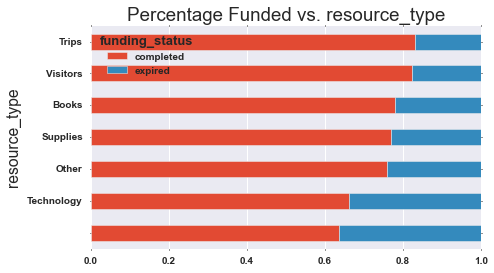

In [429]:
plot_proportions('resource_type',figSize=(7,4))

Reducing the levels to:

- trips and visitor 
- book and supplies
- Technology and other.

In [430]:
resource_type_mapping = {'Trips': 'Trips_Visitor', 'Visitors': 'Trips_Visitor',
                         'Books': 'Books_Supplies', 'Supplies': 'Books_Supplies',
                         'Other': 'Technology_other', 'Technology': 'Technology_other', '':'Technology_other'}
projects_la['resource_type_grouped'] = projects_la.resource_type.map(resource_type_mapping).astype(object)

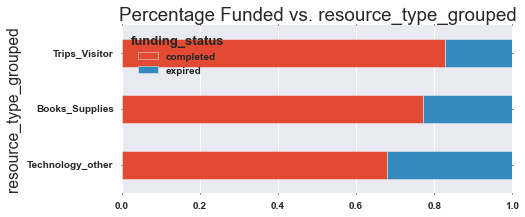

In [431]:
plot_proportions('resource_type_grouped',figSize=(7,3))

In [432]:
print 'chi2 p-value before grouping:', chi2_test('resource_type')
print 'chi2 p-value after grouping:', chi2_test('resource_type_grouped')

chi2 p-value before grouping: 6.25175307952e-170
chi2 p-value after grouping: 9.53369323619e-132


Not bad! $10^{-132}$ is still pretty good! haha! Handling three levels is for sure easier.

### Project Focus Subject & Area

DonorsChoose 'Focus Area' is one way of grouping the 'Focus Subjects'. This grouping is based on context similarity of different subjects. For example, three 'Music & The Arts' different subjects fit into this docus area. See below for more details:

In [433]:
list(projects_la.primary_focus_area.unique())

['Applied Learning',
 'Math & Science',
 'Literacy & Language',
 'History & Civics',
 'Special Needs',
 'Health & Sports',
 'Music & The Arts',
 '']

In [434]:
list(projects_la.primary_focus_subject.unique())

['Other',
 'Health & Life Science',
 'Literature & Writing',
 'Literacy',
 'Social Sciences',
 'Mathematics',
 'ESL',
 'Special Needs',
 'Health & Wellness',
 'History & Geography',
 'Extracurricular',
 'Visual Arts',
 'Gym & Fitness',
 'Sports',
 'Applied Sciences',
 'Environmental Science',
 'College & Career Prep',
 'Character Education',
 'Music',
 'Early Development',
 'Performing Arts',
 'Foreign Languages',
 'Civics & Government',
 'Community Service',
 'Economics',
 'Nutrition',
 'Parent Involvement',
 '']

The goal is to regroup the subjects heuristically to gain more variation (information).

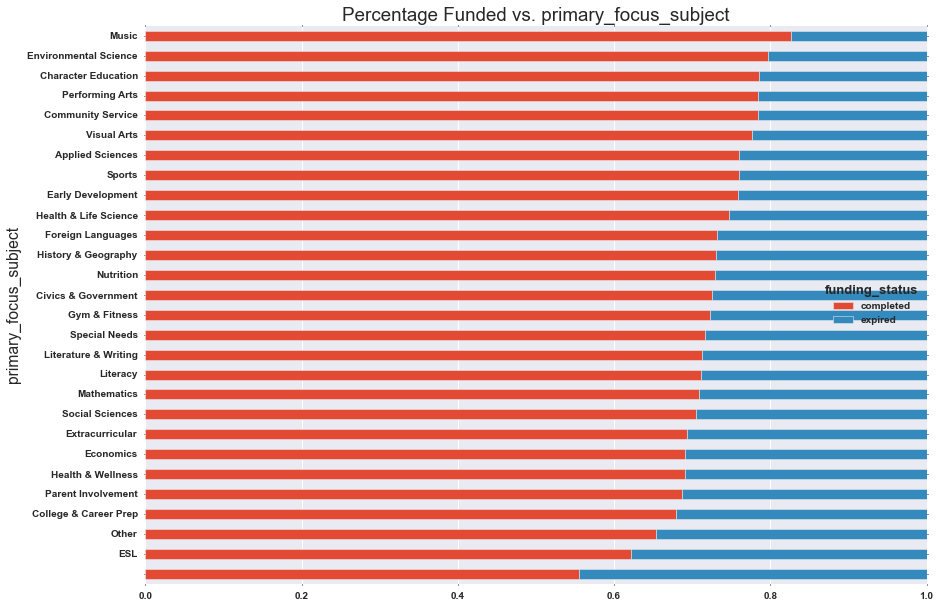

In [435]:
plot_proportions('primary_focus_subject',figSize=(14,10))

Grouping is not done solely based on similarity of the subjects but also funding status distribution. For example, It seems that math & literacy have a similar popularity level in LA!

Reducing the levels to:


- music and art ('Visual Arts','Music','Performing Arts')
- community related ('Early Development','Environmental Science','Character Education','Community Service','Applied Sciences')
- health and sports ('Health & Life Science','Health & Wellness','Gym & Fitness', 'Sports','Nutrition','Special Needs')
- literacy and math ('Literature & Writing','Literacy','Foreign Languages','ESL','Mathematics')
- history and civics ('Social Sciences','History & Geography','Civics & Government','Economics')
- Other ('Other','Extracurricular','College & Career Prep','Parent Involvement','')

In [436]:
primary_subject_mapping = {'Visual Arts': 'music_art', 'Music': 'music_art', 'Performing Arts': 'music_art',
                          'Early Development': 'community_related', 'Environmental Science': 'community_related',
                          'Character Education': 'community_related', 'Community Service': 'community_related',
                           'Applied Sciences': 'community_related', 'Health & Life Science': 'health' , 
                           'Health & Wellness': 'health', 'Gym & Fitness': 'health', 'Sports': 'health',
                           'Nutrition': 'health', 'Literature & Writing': 'literacy_math', 'Literacy': 'literacy_math',
                           'Foreign Languages': 'literacy_math', 'ESL': 'literacy_math' ,'Mathematics': 'literacy_math',
                           'Social Sciences': 'history_civics','History & Geography': 'history_civics',
                           'Civics & Government': 'history_civics', 'Economics': 'history_civics', 'Other': 'other',
                           'Extracurricular': 'other', 'College & Career Prep': 'other', 'Special Needs': 'health',
                           'Parent Involvement': 'other','': 'other'}

projects_la['primary_focus_subject_grouped'] = projects_la.primary_focus_subject.map(primary_subject_mapping).astype(object)

# Have to apply the same grouping to the secondary subject
projects_la['secondary_focus_subject_grouped'] = projects_la.secondary_focus_subject.map(primary_subject_mapping).astype(object)

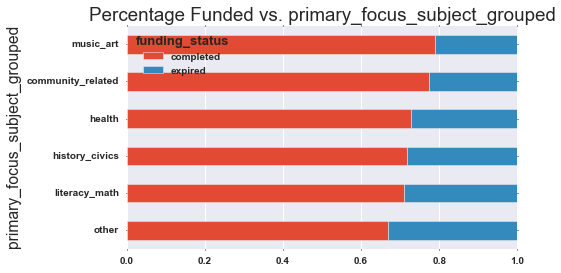

In [437]:
plot_proportions('primary_focus_subject_grouped',figSize=(7,4))

In [438]:
print 'chi2 p-value before grouping:', chi2_test('primary_focus_subject')
print 'chi2 p-value after grouping:', chi2_test('primary_focus_subject_grouped')

chi2 p-value before grouping: 7.6262626851e-57
chi2 p-value after grouping: 5.32516957848e-57


Fantastic! After grouping, p-value is much more significant that what we got for primary_focus_area even that primary_focus_area has more levels.

### Poverty Level

It is interesting that schools with lower poverty level are more likely to receive the fund! But their fraction is much lower. So in general more money goes to high poverty schools.

Let's make it only two levels: Low & High Poverty.

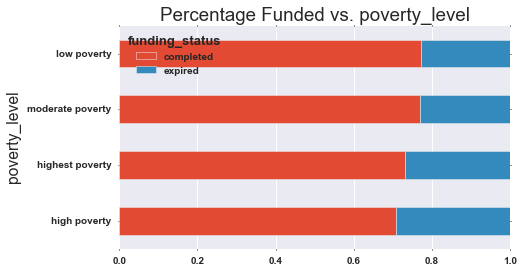

In [439]:
plot_proportions('poverty_level',figSize=(7,4))

In [440]:
projects_la.poverty_level.value_counts()

highest poverty     28633
high poverty        19095
moderate poverty     4696
low poverty          1643
dtype: int64

In [441]:
poverty_level_mapping = {'highest poverty': 'high', 'high poverty': 'high',
                         'moderate poverty': 'low', 'low poverty': 'low'}
projects_la['poverty_level_grouped'] = projects_la.poverty_level.map(poverty_level_mapping).astype(object)

### Teacher's Gender

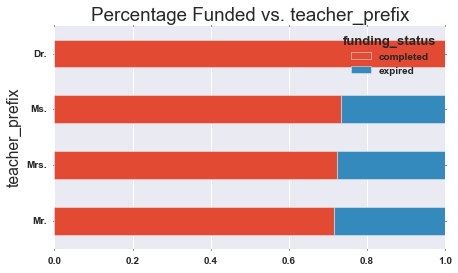

In [442]:
plot_proportions('teacher_prefix',figSize=(7,4))

Will group them to male and female. What about the doctors? There are only three projects and it's written by the same person. I am going to assume it's a guy.

In [443]:
projects_la[projects_la.teacher_prefix == 'Dr.']['_teacher_acctid']

9503     """404702a13021b313cd746b88754da842"""
15642    """404702a13021b313cd746b88754da842"""
40508    """404702a13021b313cd746b88754da842"""
Name: _teacher_acctid, dtype: object

In [444]:
teacher_gender_mapping = {'Dr.': 'male', 'Mr.': 'male',
                         'Ms.': 'female', 'Mrs.': 'female'}
projects_la['teacher_gender'] = projects_la.teacher_prefix.map(teacher_gender_mapping).astype(object)

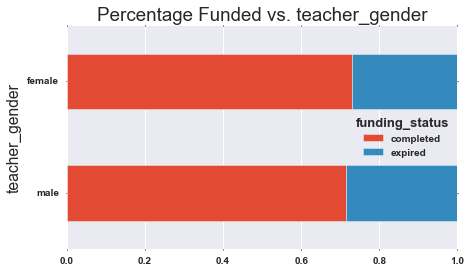

In [445]:
plot_proportions('teacher_gender',figSize=(7,4))

# Analyzing Numerical Variables

In [446]:
numerical_variables = projects_la[['vendor_shipping_charges', 'sales_tax','payment_processing_charges', 
                                    'fulfillment_labor_materials','total_price_excluding_optional_support',
                                    'total_price_including_optional_support', 'students_reached',
                                    'total_donations','num_donors']]

### Comparing the Medians of Funded and Not Funded Projects Using Bootstrap 

In [447]:
for each in numerical_variables:
    bootstrap_median(each,2000,2000)

The mean of median difference of vendor_shipping_charges is -2.88, the confidence interval=(-7.0,-0.49), and  p-value=0.09.

The mean of median difference of sales_tax is -6.58, the confidence interval=(-7.72,-5.41), and  p-value=0.0.

The mean of median difference of payment_processing_charges is -1.28, the confidence interval=(-1.71,-0.83), and  p-value=0.0.

The mean of median difference of fulfillment_labor_materials is -2.85, the confidence interval=(-5.0,0.0), and  p-value=0.28.

The mean of median difference of total_price_excluding_optional_support is -90.71, the confidence interval=(-119.15,-67.51), and  p-value=0.0.

The mean of median difference of total_price_including_optional_support is -106.86, the confidence interval=(-138.07,-79.76), and  p-value=0.0.

The mean of median difference of students_reached is 0.01, the confidence interval=(0.0,0.0), and  p-value=0.96.

The mean of median difference of total_donations is 500.85, the confidence interval=(486.13,515.59), and  

Not surprisingly, number of donors and total donations are strong indicators of the success. But it's interesting to see how the amount of money teachers ask for is so effective. Sales tax, shipping, and processing charges are highly correlated with the total price. And it seems that fulfillment fee is independent of funding status. 

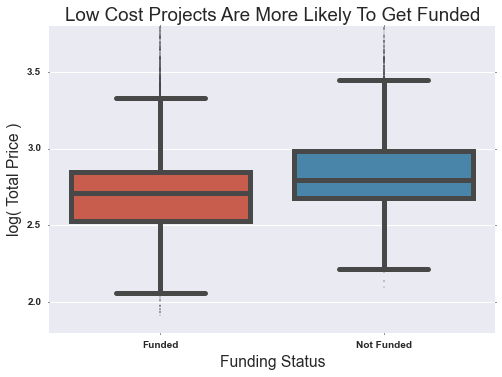

In [448]:
sns.set_style("darkgrid",{"xtick.major.size": 1, "ytick.major.size": 1,'axes.labelsize': 15,\
                          'axes.titlesize': 32, 'font.size': 32, 'legend.fontsize': 32.0})

g = sns.boxplot(np.log10(projects_la.total_price_including_optional_support), groupby=projects_la.funding_status,\
            names=['Funded','Not Funded'], fliersize=1, linewidth=5, widths=0.8, saturation=0.7, \
            label='log10(Total Price)')
g.set(ylim=(1.8, 3.8))
g.set_title('Low Cost Projects Are More Likely To Get Funded')
sns.axlabel('Funding Status','log( Total Price )')

# Analyzing Timestamp Variables

Let's see in there is a correlation between the success rate and the project posting dates in terms of year, month, and weekdays.

In [449]:
projects_la['weekday_posted'] = projects_la['date_posted'].apply(lambda x: x.weekday())
projects_la['month_posted'] = projects_la['date_posted'].apply(lambda x: x.month)
projects_la['year_posted'] = projects_la['date_posted'].apply(lambda x: x.year)

### Success Rate vs. Weekday Posted 

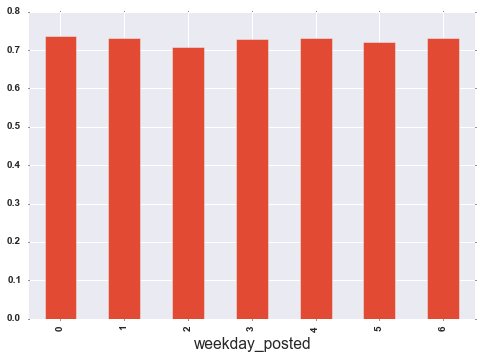

In [450]:
projects_la.groupby('weekday_posted').funding_status_binary.mean().plot('bar')

Doesn't seem like it!

### Success Rate vs. Month Posted 

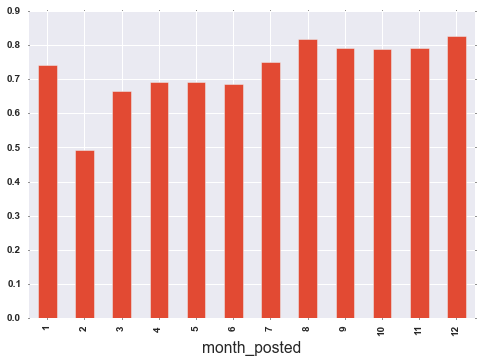

In [451]:
projects_la.groupby('month_posted').funding_status_binary.mean().plot('bar')

Wow! A big difference. Let's group them into first and second semester. 

In [452]:
projects_la['semester_posted'] = 0

for index,row in projects_la.iterrows():
    if row['month_posted'] < 7:
        projects_la.ix[index,'semester_posted'] = '2nd'
    elif row['month_posted'] >= 7:
        projects_la.ix[index,'semester_posted'] = '1st'

In [453]:
projects_la.semester_posted.value_counts()

2nd    27647
1st    26420
dtype: int64

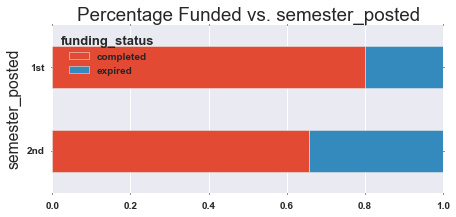

In [454]:
plot_proportions('semester_posted',figSize=(7,3))

Very good!

### Success Rate vs. Year Posted

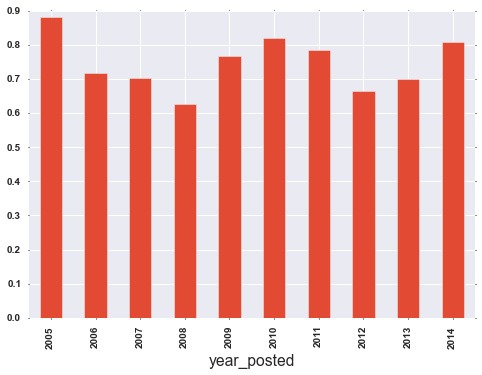

In [455]:
projects_la.groupby('year_posted').funding_status_binary.mean().plot('bar')

Interesting! 2008 collapse clearly had an impact. Anyway, the year posted in not going to be part of my modeling.

# More Feature Engineering

Possibly, teachers who have posted more projects in the past have a higher chance. 

## Number of Teacher's Previous Projects 

In [456]:
projects_la['previousProposal_Teacher'] = 0

# Create a dictionary for the number of previouse proposals by a teacher
# All initial values are zero
teach_dict = projects_la.set_index('_teacher_acctid')['previousProposal_Teacher'].to_dict()
for each in projects_la._teacher_acctid:
    teach_dict[each] += 1

# Create a list of all values --> much faster than updating each row
previousProposal = []
for i in xrange(len(projects_la._teacher_acctid)):
    previousProposal.append(teach_dict[projects_la._teacher_acctid[i]])

# Finally updating the column
projects_la['previousProposal_Teacher'] = previousProposal

In [457]:
bootstrap_median('previousProposal_Teacher',2000,2000)

The mean of median difference of previousProposal_Teacher is 2.0, the confidence interval=(2.0,2.0), and  p-value=0.0.



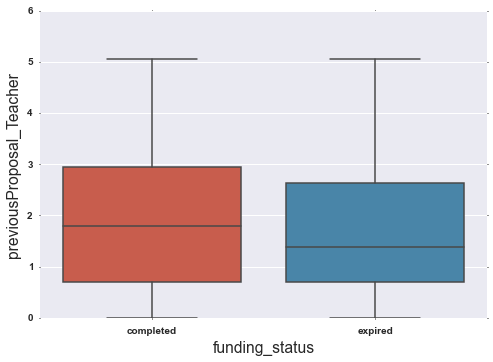

In [458]:
sns.boxplot(np.log(projects_la.previousProposal_Teacher),groupby=projects_la.funding_status)

Okay, so there is a difference.

## Number of School Previous Projects 

In [459]:
projects_la['previousProposal_School'] = 0

# Create a dictionary for the number of previouse proposals by a teacher
# All initial values are zero
school_dict = projects_la.set_index('_schoolid')['previousProposal_School'].to_dict()
for each in projects_la._schoolid:
    school_dict[each] += 1

# Create a list of all values --> much faster than updating each row
previousProposal = []
for i in xrange(len(projects_la._schoolid)):
    previousProposal.append(school_dict[projects_la._schoolid[i]])

# Finally updating the column
projects_la['previousProposal_School'] = previousProposal

In [460]:
bootstrap_median('previousProposal_School',2000,2000)

The mean of median difference of previousProposal_School is 8.13, the confidence interval=(3.0,13.0), and  p-value=0.0.



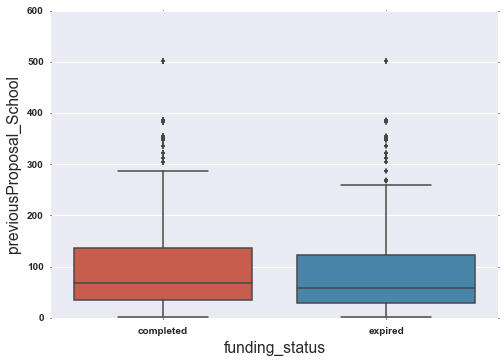

In [461]:
sns.boxplot(projects_la.previousProposal_School,groupby=projects_la.funding_status)

## Number of Donors  & Total Donations  per Zipcode

Does it matter how many donors and how much have contrbuted to the projects in LA per zipcode.

In [462]:
num_donors_per_zip = projects_la.groupby('school_zip').num_donors.sum()
num_donors_per_zip_dict = num_donors_per_zip.to_dict()
projects_la['donor_per_zip'] = projects_la.school_zip.map(lambda x: num_donors_per_zip_dict[x])

donations_per_zip = projects_la.groupby('school_zip').total_donations.sum()
donations_per_zip_dict = donations_per_zip.to_dict()
projects_la['donation_per_zip'] = projects_la.school_zip.map(lambda x: donations_per_zip_dict[x])

projects_la.head()

,_projectid,_teacher_acctid,_schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_zip,school_metro,school_district,...,poverty_level_grouped,teacher_gender,weekday_posted,month_posted,year_posted,semester_posted,previousProposal_Teacher,previousProposal_School,donor_per_zip,donation_per_zip
0,"""""""2d5b520776306c5045773b5967b2489b""""""","""""""e4c4e0f20f829889bf5dea5b86a53167""""""","""""""5eb8abe6cd0a27efa1287f147dc40569""""""",060962000970,33.884496,-118.261193,Carson,90746,urban,Compton Unified School Dist,...,high,female,4,8,2005,1st,25,312,1713,187579.60
1,"""""""0034afc6a1b71df3cc9927b353b21677""""""","""""""80e001267354e9e6b61eb08a37d5e7a7""""""","""""""5eb8abe6cd0a27efa1287f147dc40569""""""",060962000970,33.884496,-118.261193,Carson,90746,urban,Compton Unified School Dist,...,high,male,0,8,2005,1st,57,312,1713,187579.60
2,"""""""d418d916e635e3bce6f8b3a4958f0fda""""""","""""""60e8acc2d87acea355900bd27fb0602f""""""","""""""bee98bc28f4e5877c3a0dcfb1afe2203""""""",062271003017,34.019176,-118.306340,Los Angeles,90018,urban,Los Angeles Unif Sch Dist,...,high,female,4,8,2005,1st,4,33,2296,120139.60
3,"""""""1fa48a4ff77363363c5c32ab6d9ef89b""""""","""""""80e001267354e9e6b61eb08a37d5e7a7""""""","""""""5eb8abe6cd0a27efa1287f147dc40569""""""",060962000970,33.884496,-118.261193,Carson,90746,urban,Compton Unified School Dist,...,high,male,0,8,2005,1st,57,312,1713,187579.60
4,"""""""3c6448cd34bb451adf5ced0e56da4cc9""""""","""""""1dae23a46c9880f565278725ce8064a0""""""","""""""439e18432181f6357930db095bf938a4""""""",060962000991,33.900922,-118.261918,Compton,90220,urban,Compton Unified School Dist,...,high,female,2,8,2005,1st,2,70,2505,210515.95


In [463]:
bootstrap_median('donation_per_zip',nofSimulation=2000,nofSample=2000)
bootstrap_median('donor_per_zip',nofSimulation=2000,nofSample=2000)

The mean of median difference of donation_per_zip is 3001.5, the confidence interval=(-2000.28,10839.64), and  p-value=0.38.

The mean of median difference of donor_per_zip is 33.17, the confidence interval=(-236.0,262.0), and  p-value=0.8.



Nope! No dependence!

# Writing The Potentially Important Variable

In [464]:
projects_la.columns

Index([u'_projectid', u'_teacher_acctid', u'_schoolid', u'school_ncesid',
       u'school_latitude', u'school_longitude', u'school_city', u'school_zip',
       u'school_metro', u'school_district', u'school_charter',
       u'school_magnet', u'school_year_round', u'school_kipp',
       u'school_charter_ready_promise', u'teacher_prefix',
       u'teacher_teach_for_america', u'primary_focus_subject',
       u'primary_focus_area', u'secondary_focus_subject',
       u'secondary_focus_area', u'resource_type', u'poverty_level',
       u'grade_level', u'vendor_shipping_charges', u'sales_tax',
       u'payment_processing_charges', u'fulfillment_labor_materials',
       u'total_price_excluding_optional_support',
       u'total_price_including_optional_support', u'students_reached',
       u'total_donations', u'num_donors', u'eligible_double_your_impact_match',
       u'eligible_almost_home_match', u'funding_status', u'date_posted',
       u'date_completed', u'date_thank_you_packet_mailed', u'dat

In [465]:
projects_la.drop(['_teacher_acctid', '_schoolid','school_ncesid','date_completed','school_latitude',
                  'primary_focus_subject','primary_focus_area','secondary_focus_subject','secondary_focus_area',
                  'school_longitude','school_city','school_district','teacher_prefix','vendor_shipping_charges',
                  'sales_tax','payment_processing_charges','fulfillment_labor_materials','total_donations',
                  'num_donors','resource_type','poverty_level','date_posted','date_completed',
                  'date_thank_you_packet_mailed','date_expiration','weekday_posted','year_posted'], axis=1, inplace=True)

In [466]:
projects_la.to_csv('projects_preProcessed.csv',index=False)